In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [2]:
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of poping up a new window. More about that later. 
%pylab inline
%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [3]:
n_samples = 1024
learning_rate = 0.01
training_epochs = 1000
display_step = 50

In [4]:
# Create an interactive session, to make code easier to write.
s1 = tf.InteractiveSession()
s1

# Initialize Tensorflow model variables

In [5]:
w1 = tf.Variable(np.random.rand(1)[0], trainable=True, dtype=tf.float32, name='w1')
w1.initializer.run()
w1

In [6]:
w2 = tf.Variable(np.random.rand(1)[0], trainable=True, dtype=tf.float32, name='w2')
w2.initializer.run()
w2

In [7]:
b  = tf.Variable(np.random.rand(1)[0], trainable=True, dtype=tf.float32, name='b')
b.initializer.run()
b

# Initialize Tensorflow model placeholders

In [8]:
_x1 = tf.placeholder("float32", name='x1')
_x1

<tf.Tensor 'x1:0' shape=<unknown> dtype=float32>

In [9]:
_x2 = tf.placeholder("float32", name='x1')
_x2

<tf.Tensor 'x1_1:0' shape=<unknown> dtype=float32>

In [10]:
_y  = tf.placeholder("float32", name='y')
_y

<tf.Tensor 'y:0' shape=<unknown> dtype=float32>

# Initalize output and cost model functions

$$y = w_1 x_1 + w_2 x_2 + b$$

In [11]:
y = w1 * _x1 + w2 * _x2 + b
#y = tf.py_func(w1 * _x1 + w2 * _x2 + b,[_x1,_x2], [tf.float32], name='y')[0]
y

<tf.Tensor 'add_1:0' shape=<unknown> dtype=float32>

$$cost = \frac{1}{2N} \sum_n (pred-target)^2$$

In [12]:
cost = tf.reduce_sum(tf.pow(y-_y, 2))/(2*n_samples)
#cost = tf.py_func(tf.reduce_sum(tf.pow(y-_y, 2))/(2*n_samples), [_y], [tf.float32], name='cost')[0]
cost

<tf.Tensor 'div:0' shape=<unknown> dtype=float32>

# Generate data

In [13]:
from generate_xyz_data import generate_xyz_data

In [14]:
help(generate_xyz_data)

Help on function generate_xyz_data in module generate_xyz_data:

generate_xyz_data(delta=0.05, minRange=-3.0, maxRange=3.0, nDistributions=0, variances=[], means=[], signs=[], ranges=())



In [15]:
delta = 0.1
minRange = -10.0
maxRange = 10.0
ranges = (1, 1, 50)


nDistributions = 10
means = np.zeros((nDistributions,2))
variances = np.zeros((nDistributions,2))
signs = np.zeros((nDistributions,1))
for i in range(1,nDistributions+1):
    means[i-1][0] = 10 * (np.random.rand() - 0.5)
    means[i-1][1] = 10 * (np.random.rand() - 0.5)
    variances[i-1][0] = 1
    variances[i-1][1] = 1
    signs[i-1] = (-1)**i
    #print(signs[i-1])

#means = [(0.0, 0.0), (1.0, 1.0), (1.0, 10.0)]
#variances = [(1.0, 1.0), (1.0, 0.5), (0.5, 0.5)]
#signs = [-1, 1, -1]

In [16]:
X1, X2, Y = generate_xyz_data(delta, minRange, maxRange, nDistributions, variances, means, signs, ranges)
shapes = (X1.shape, X2.shape, Y.shape)
print(shapes)

((200, 200), (200, 200), (200, 200))


# Visualize the training data

<IPython.core.display.Javascript object>


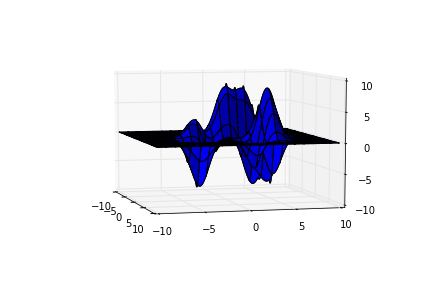

In [17]:
# Plot a basic wireframe.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X1, X2, Y, rstride=10, cstride=10)

plt.show()

# Obtain training data

In [18]:
maxS = np.max(shapes)
idx = np.random.choice(maxS**2,n_samples,replace=False)

trX1 = X1.flatten()[idx[:]]
trX2 = X2.flatten()[idx[:]]
trY  = Y.flatten()[idx[:]]

tr   = zip(trX1, trX2, trY)

# Some details about the Tensorflow operators

Let's take a look at how you can [1] call functions you created with Tensorflow and [2] how do get the gradients of those functions.

### Evalute '_y_' and '_cost_' functions

In [19]:
# Just put, in the feed_dict argument, the values you want to pass to the function. 
# Then invoke the Op.eval method. Profit!

print(y.eval(feed_dict={_x1: trX1, _x2: trX2}))

print(cost.eval(feed_dict={_x1: trX1, _x2: trX2, _y: trY}))

[-4.86586714  2.14996624 -2.91740251 ..., -7.70248556 -0.13058609
  5.00639486]
13.5599


### Obtain the gradient operators (because I can, don't question me)

In [20]:
# Derivative of the cost function in relation to y.
DcostDy = tf.gradients(cost, y)[0]

In [21]:
# Derivative of the cost function in relation to w1.
DcostDw1 = tf.gradients(cost, w1)[0]

In [22]:
# Derivative of the cost function in relation to w2.
DcostDw2 = tf.gradients(cost, w2)[0]

In [23]:
# Derivative of y in relation to w1.
DyDw1 = tf.gradients(y, w1)[0]

In [24]:
# Derivative of y in relation to w2.
DyDw2 = tf.gradients(y, w2)[0]

To get the value of the an **individual** gradient at a specific point, you can do:

In [25]:
DyDw2.eval(feed_dict={_x1: trX1[0], _x2: trX2[0]})

-1.0

If you use a batch of inputs, you will get the **aggregated gradient**:

In [26]:
DyDw2.eval(feed_dict={_x1: trX1, _x2: trX2})

314.60001

You might think "well, if I need each individual gradient of the batch, maybe I could define a cost function like this":

In [27]:
cost2 = tf.pow(y-_y, 2)/(2*n_samples)
Dcost2Dw2 = tf.gradients(cost2, w2)[0]

In [28]:
print(cost2.eval(feed_dict={_x1: trX1, _x2: trX2, _y: trY}))

[ 0.01156091  0.0020927   0.0041425  ...,  0.02896889  0.00889962
  0.01233461]


So, unlike the _cost_ function, with _cost2_, you get a batch of results! But what happens if we evaluate $\frac{\partial cost2}{\partial w_2}$ with the input batch? Let's find out!

In [29]:
print(DcostDw2.eval(feed_dict={_x1: trX1, _x2: trX2, _y: trY}))
print(Dcost2Dw2.eval(feed_dict={_x1: trX1, _x2: trX2, _y: trY}))

19.4574
19.4574


Hmmm, Tensorflow still returns the **aggregated** gradient. So, it seems you can only get the **individual** gradient by evaluating the gradient function, **individually**, for each input tupple of the batch.

This subject was discussed at <https://github.com/tensorflow/tensorflow/issues/4897>.

In [30]:
individualGradsDcostDw2 = np.zeros((max(idx.shape)))
for i in range(np.max(individualGradsDcostDw2.shape)): 
    individualGradsDcostDw2[i] = Dcost2Dw2.eval(feed_dict={_x1: trX1[i], _x2: trX2[i], _y: trY[i]})

print(individualGradsDcostDw2)

[ 0.00475183  0.00363908  0.02161773 ...,  0.03836199 -0.01709364
  0.03975692]


# Learning the model

First, we create an optimizer object. Let's settle with a simple gradient descent.

In [31]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

Now, let's use that optimizer object with the entire training batch, for a number of epochs

In [33]:
for epoch in range(training_epochs): 
    s1.run(optimizer, feed_dict={_x1: trX1, _x2: trX2, _y: trY})
    print(cost.eval(feed_dict={_x1: trX1, _x2: trX2, _y: trY}))

7.17773
4.33673
3.07064
2.50561
2.25292
2.13952
2.0883
2.06485
2.05384
2.04841
2.04547
2.04367
2.04239
2.04135
2.04043
2.03957
2.03875
2.03795
2.03717
2.03641
2.03566
2.03493
2.03422
2.03352
2.03283
2.03215
2.03149
2.03085
2.03021
2.02959
2.02898
2.02838
2.0278
2.02722
2.02666
2.02611
2.02557
2.02504
2.02452
2.02401
2.02351
2.02302
2.02255
2.02208
2.02162
2.02116
2.02072
2.02029
2.01986
2.01945
2.01904
2.01864
2.01825
2.01786
2.01749
2.01712
2.01675
2.0164
2.01605
2.01571
2.01538
2.01505
2.01473
2.01441
2.0141
2.0138
2.01351
2.01322
2.01293
2.01265
2.01238
2.01211
2.01185
2.01159
2.01134
2.01109
2.01085
2.01061
2.01038
2.01015
2.00993
2.00971
2.00949
2.00928
2.00907
2.00887
2.00867
2.00848
2.00829
2.0081
2.00792
2.00774
2.00756
2.00739
2.00722
2.00706
2.00689
2.00673
2.00658
2.00642
2.00628
2.00613
2.00598
2.00584
2.0057
2.00557
2.00544
2.00531
2.00518
2.00505
2.00493
2.00481
2.00469
2.00458
2.00446
2.00435
2.00424
2.00414
2.00403
2.00393
2.00383
2.00373
2.00364
2.00354
2.00345
2.00336